# Определение стоимости автомобилей

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Проверим установленные пакеты

In [127]:
def check_if_installed(packages):
    for package in packages:
        try:
            exec(f'import {package}')
        except Exception as ex:
            print(ex)
            !pip install {package}
            exec(f'import {package}')


In [128]:
libs = [
    'category_encoders',
    'catboost',
    'optuna',
    'lightgbm',
]

check_if_installed(libs)


In [129]:
import lightgbm

Импортируем пакеты

In [130]:
import pandas as pd
import numpy as np
import sklearn as sk
import catboost as cb
import os

from sklearn.model_selection import train_test_split

Получаем путь до файла и загружаем его

In [131]:
BASE_DIR = os.getcwd()

In [132]:
df = pd.read_csv(f'{BASE_DIR}/datasets/autos.csv')

Первичное изучение данных

In [133]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [135]:
df.isna().sum()/df.count()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.118310
RegistrationYear     0.000000
Gearbox              0.059285
Power                0.000000
Model                0.058880
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.102326
Brand                0.000000
Repaired             0.251237
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

## Удаление признаков

Ряд признаков нам не понадобятся, можем их удалить

In [136]:
df = df.drop(['DateCrawled', 'PostalCode','RegistrationMonth','NumberOfPictures', 'LastSeen'], axis=1)

## Заполнение пропусков

### FuelType

In [137]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Признак `FuelType` содержит пропуски, заполним их новым значением.

In [138]:
df['FuelType'] = df['FuelType'].fillna('unknown');
df['FuelType'].isna().sum()

0

### GearBox

In [139]:
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Пропуски в признаке коробки передач не предсталяется возможным заполнить, также заполним их значением `unknown`

In [140]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

### VehicleType

In [141]:
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Попробуем заполнить пропуски `VehicleType` поиском по аналогичным моделям в признаке `Model`. Предположим, что каждой модели соответствует один тип.

In [142]:
df.groupby('Model').agg({'VehicleType':['unique','nunique']})

VehicleType        
                                                    unique nunique
Model                                                             
100                [nan, wagon, sedan, coupe, convertible]       4
145                      [nan, small, sedan, coupe, other]       4
147          [sedan, small, nan, wagon, coupe, suv, other]       6
156               [wagon, sedan, nan, coupe, other, small]       5
159                                    [sedan, wagon, nan]       2
...                                                    ...     ...
yaris               [small, nan, bus, other, wagon, sedan]       5
yeti                              [suv, nan, other, wagon]       3
ypsilon                          [small, nan, convertible]       2
z_reihe                   [convertible, coupe, nan, sedan]       3
zafira   [nan, bus, other, wagon, small, suv, sedan, co...       8

[250 rows x 2 columns]

Предположение оказалось ложным, мы не сможем заполнить данные таким способом. Также заполним пропуски значением `unknown`

In [143]:
df['VehicleType'] = df['VehicleType'].fillna('unknown');
df['VehicleType'].isna().sum()

0

### Model

In [144]:
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [145]:
df['Model'] = df['Model'].fillna('unknown');
df['Model'].isna().sum()

0

### Repaired

In [146]:
df['Repaired'].value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

Мы не можем удалить пропуски в признаке, как и заполнить их. Вводим новую категорию

In [147]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [148]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
DateCreated         0
dtype: int64

## Изменение данных

Извлечём год и месяц из признака `DateCreated`, предположим что цена может зависеть от года когда опубликовано объвление (например для объявлений которые выставлены очень давно цена может быть снижена) и месяца (на стоимость автомобиля может влиять сезон года).

In [149]:
df["DateCreated"] = df["DateCreated"].astype("datetime64")
# получаем информацию о годе
df["CreatedYear"] = df["DateCreated"].dt.year
# получаем информацию о месяце
df["CreatedMonth"] = df["DateCreated"].dt.month
df = df.drop("DateCreated", axis=1)

## Обработка выбросов и аномалий

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
 10  CreatedYear       354369 non-null  int64 
 11  CreatedMonth      354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


Изучим значения количественных признаков на предмет аномалий:  
Price, RegistrationYear, Power, Kilometer, CreatedYear, CreatedMonth

In [151]:
for i in df.columns:
    if df[i].dtype=='int64':
        print(df[i].describe(),end='\n\n')

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

count    354369.000000
mean       2015.999924
std           0.009046
min        2014.000000
25%        2016.000000
50%        2016.00

### Kilometer

In [152]:
df['Kilometer'].value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

Аномалии обнаружены в столбцах `Price` , `RegistrationYear`, `Power`

### Price

In [153]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:>

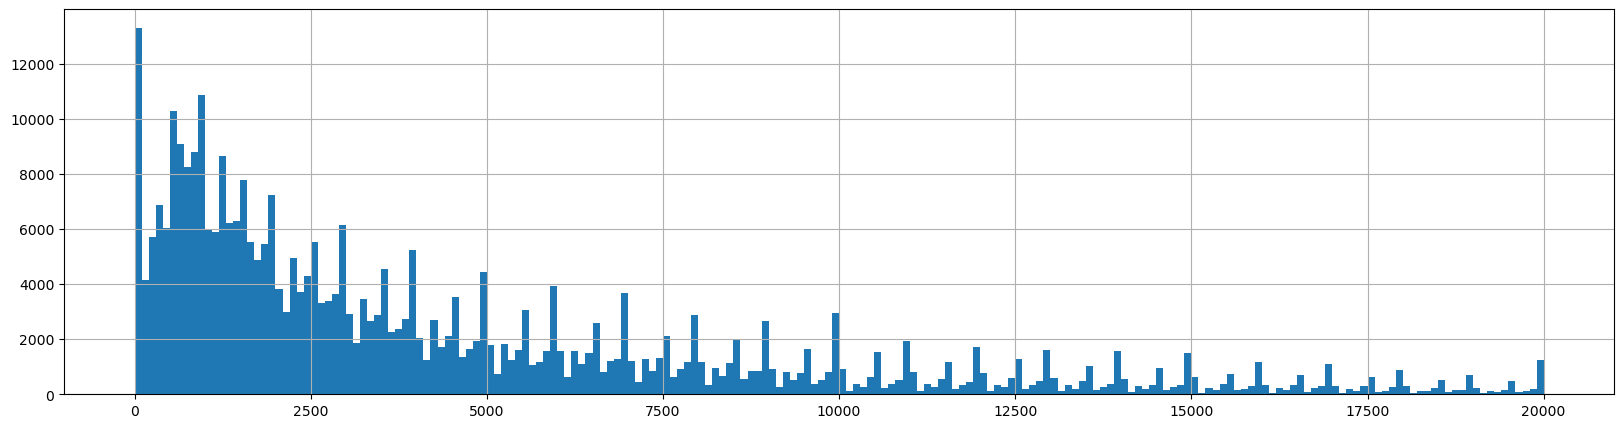

In [154]:
df['Price'].hist(bins=200, figsize=(20,5))

Большое количетсво выбросов в нулевых значениях, все ненулевые значения не будем считать выбросами. Удалим строки с такими значениями, нет смысла пытаться их заполнить т.к. это целевой признак.

In [155]:
df = df[df['Price']!=0]

### RegistrationYear

In [156]:
df['RegistrationYear'].describe()

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [157]:
print(sorted(list(df['RegistrationYear'].unique())))

[1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999]


In [158]:
df['CreatedYear'].value_counts()

2016    343571
2015        25
2014         1
Name: CreatedYear, dtype: int64

Отбросим значения до 1910 года и после 2016, т.к. постановка на учёт не может быть позже чем выставлена анкета.

In [159]:
df = df[df['RegistrationYear']<=2016]
df = df[df['RegistrationYear']>=1910]
df['RegistrationYear'].describe()

count    329765.000000
mean       2002.593583
std           6.927865
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

### Power

In [160]:
df['Power'].describe()

count    329765.000000
mean        111.902179
std         184.849228
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

На основе исследования рынка примем автомобили мощностью ниже 30л.с. и выше 1000л.с. за выбросы. Исключим такие объекты из выборки.

In [161]:
df = df[df['Power']<=1000]
df = df[df['Power']>=30]
df['Power'].describe()

count    295802.000000
mean        121.017782
std          54.655760
min          30.000000
25%          77.000000
50%         111.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64

Изучим категориальные признаки на предмет аномалий.

In [162]:
cat_features = []
num_features = []
for i in df.columns:
    if df[i].dtype=='object':
        cat_features.append(i)
    else:
        num_features.append(i)
num_features.remove('Price')

Petrol и gasoline это буквально одно и то же, объединим эти категории.

In [163]:
df['FuelType'].replace('gasoline', 'petrol', inplace=True)

In [164]:
df['FuelType'].value_counts()

petrol      274852
unknown      15480
lpg           4687
cng            483
hybrid         202
other           59
electric        39
Name: FuelType, dtype: int64

**Вывод**
  
На этапе подготовки данных были удалены признаки не влияющие на обучения модели.  
Пропуски в категориальных признаках заполнены категорией `unknown`.  
Из признака `DateCreated` извлечены год и месяц публикации объявления, сам признак был удалён.  
Были обработаны аномалии в данных.  


## Подготовка данных к обучению

Забегая вперёд, были проверены два варианта обработки пропусков, заполнение категорией `unknown` и удаления объектов с пропусками, второй подход показал себя лучше во всех используемых моделях без исключения. Удалим пропуски из данных.

In [165]:
for i in cat_features:
    df.drop(df[df[i] == 'unknown'].index, axis=0, inplace=True)

Разделим выборку на обучающую и тестовую

In [166]:
features = df.drop('Price', axis=1)
target = df['Price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

## Обучение моделей

### Linear Regression

In [167]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import CatBoostEncoder
from category_encoders.count import CountEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [168]:
# # создаем список кодировщиков, которые нужно протестировать
# encoders = [
#     ('cbe', CatBoostEncoder(), cat_features),
#     ('oe', CountEncoder(), cat_features),
#     ('te', TargetEncoder(), cat_features),
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
# ]

In [169]:
# for encoder in encoders:
#     preprocessor = ColumnTransformer([
#         encoder,
#         ('scaler', StandardScaler(), num_features),
#     ])

#     pipe_lr = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', LinearRegression())
#     ])

#     scores = cross_val_score(
#         pipe_lr,
#         features_train, 
#         target_train,
#         cv=5,
#         scoring='neg_mean_squared_error',
#     );
    
#     print(f'RMSE {(-scores.mean())**0.5}')

Лучший результат Linear Regression:  
RMSE: 2541  
Encoder: OHE

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# создаем список кодировщиков, которые нужно протестировать
encoders = [
    ('cbe', CatBoostEncoder(), cat_features),
    ('oe', CountEncoder(), cat_features),
    ('te', TargetEncoder(), cat_features),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
]
for encoder in encoders:
    preprocessor = ColumnTransformer([
        encoder,
        ('scaler', StandardScaler(), num_features),
    ])

    pipe_dt = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state = 1))
    ])

    params = {
        'regressor__max_depth': range(13,14)
    }

    grid = GridSearchCV(
        estimator=pipe_dt,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
    )

    grid.fit(features_train, target_train)

    print(f'RMSE {(-grid.best_score_ )**0.5}')
    print(f'RMSE {grid.best_params_ }')


Лучший результат Decision Tree:  
RMSE: 1811  
Encoder: Target Encoder  
Max_depth: 13

### Random Forest

In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [174]:
# # создаем список кодировщиков, которые нужно протестировать
# encoders = [
#     ('cbe', CatBoostEncoder(), cat_features),
#     ('oe', CountEncoder(), cat_features),
#     ('te', TargetEncoder(), cat_features),
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
# ]

In [175]:
# for encoder in encoders:
#     preprocessor = ColumnTransformer([
#         encoder,
#         ('scaler', StandardScaler(), num_features),
#     ])

#     pipe_dt = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', RandomForestRegressor(random_state=1))
#     ])

#     params = {
#         'regressor__max_depth': [19],
#         'regressor__n_estimators': [143],
#     }

#     grid = GridSearchCV(
#         estimator=pipe_dt,
#         param_grid=params,
#         cv=5,
#         n_jobs=-1,
#         scoring='neg_mean_squared_error',
#     )

#     grid.fit(features_train, target_train)

#     print(f'RMSE {(-grid.best_score_ )**0.5}')
#     print(f'RMSE {grid.best_params_ }')


Лучший результат Random Forest:  
RMSE: 1563  
Encoder: Target Encoder  
Max Depth: 19  
N_Estimators: 143  

### LightGBM

In [176]:
import lightgbm as lgb
import optuna
from optuna.integration import OptunaSearchCV

In [177]:
# # создаем список кодировщиков, которые нужно протестировать
# encoders = [
#     ('cbe', CatBoostEncoder(), cat_features),
#     ('oe', CountEncoder(), cat_features),
#     ('te', TargetEncoder(), cat_features),
#     ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
# ]

In [178]:
# for encoder in encoders:
#     preprocessor = ColumnTransformer([
#         encoder,
#         ('scaler', StandardScaler(), num_features),
#     ])
    
#     pipe = Pipeline(steps=[
#         ('preprocessor', preprocessor), 
#         ('reg', lgb.LGBMRegressor(random_state=1))
#     ])

#     param_dist = {
#         'reg__boosting_type':optuna.distributions.CategoricalDistribution(['gbdt', 'dart', 'goss']),
#         'reg__learning_rate': optuna.distributions.FloatDistribution(0.1, 0.5, 0.05),
#         'reg__n_estimators': optuna.distributions.IntDistribution(100, 300, 30),
#         'reg__num_leaves': optuna.distributions.IntDistribution(10, 200, 15),
#         'reg__max_depth': optuna.distributions.IntDistribution(6, 20, 2),
#         'reg__subsample_for_bin': optuna.distributions.IntDistribution(1000, 200000, 1000),
#         'reg__min_child_samples': optuna.distributions.IntDistribution(100, 500, 50),
#         'reg__random_state': optuna.distributions.IntDistribution(1, 1000, 1),
#         'reg__colsample_bytree': optuna.distributions.FloatDistribution(0.2, 1, 0.1)
#         }
    
#     search_cv = OptunaSearchCV(
#         estimator=pipe,
#         param_distributions=param_dist,
#         scoring='neg_root_mean_squared_error',
#         verbose=-1,
#         n_jobs=-1,
#         n_trials=100,
#         cv=5,
#         random_state=1
#     )

#     search_cv.fit(features_train, target_train)
#     print(- search_cv.best_score_, search_cv.best_estimator_)


Лучший результат LGBMRegressor:  
RMSE = 1538  
Encoder = Target Encoder  
colsample_bytree=0.966173162680882  
learning_rate=0.20960160828429944  
max_depth=14  
min_child_samples=101  
n_estimators=299  
num_leaves=82  
random_state=108  
subsample_for_bin=4051  

## Анализ моделей

### Linear Regression:  

Лучший результат Linear Regression:  
RMSE: 2541  
Encoder: OHE

Линейная регрессия не соответствует условию `RMSE`<2500. Далее эту модель мы не рассматриваем.

### Подготовка к анализу моделей

Т.к. все остальные модели показали лучший результат с `TargetEncoder` можем сразу закодировать признаки для всех моделей.

In [179]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25)

In [180]:
cat_encoder = TargetEncoder()
features_train = cat_encoder.fit_transform(features_train, target_train);
features_valid = cat_encoder.transform(features_valid);
features_test = cat_encoder.transform(features_test);

Напишем функции для оценки времени работы моделей

In [181]:
import time

def train_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    return (model, f'{end_time - start_time:.4f}')

def predict_model(model, X_train):
    start_time = time.time()
    prediction = model.predict(X_train)
    end_time = time.time()
    return (prediction, f'{end_time - start_time:.4f}')

### Decision Tree

Лучший результат Decision Tree:  
RMSE: 1811  
Encoder: Target Encoder  
Max_depth: 13

In [182]:
model_dt =  DecisionTreeRegressor(
    random_state=1,
    max_depth=13,
)

model_dt, train_time = train_model(model_dt, features_train, target_train)
prediction, prediction_time = predict_model(model_dt, features_valid)
rmse = mean_squared_error(target_valid, prediction)**0.5

dt_dict = {
    'Model': 'Decision Tree',
    'RMSE': rmse,
    'Fit time' : train_time,
    'Predict time' : prediction_time,
}

In [183]:
dt_dict

{'Model': 'Decision Tree',
 'RMSE': 1811.4119282713457,
 'Fit time': '0.4170',
 'Predict time': '0.0150'}

### Random Forest

Лучший результат Random Forest:  
RMSE: 1563  
Enсoder: Target Encoder  
Max Depth: 19  
N_Estimators: 143  

In [184]:
model_rf = RandomForestRegressor(
    random_state=1,
    max_depth=19,
    n_estimators=143,
)

model_rf, train_time = train_model(model_rf, features_train, target_train)
prediction, prediction_time = predict_model(model_rf, features_valid)
rmse = mean_squared_error(target_valid, prediction)**0.5

rf_dict = {
    'Model': 'Random Forest',
    'RMSE': rmse,
    'Fit time' : train_time,
    'Predict time' : prediction_time,
}

In [185]:
rf_dict

{'Model': 'Random Forest',
 'RMSE': 1565.943555971756,
 'Fit time': '55.9672',
 'Predict time': '1.8300'}

### LightGBM

Лучший результат LGBMRegressor:  
RMSE = 1538  
Encoder = Target Encoder  
colsample_bytree=0.966173162680882  
learning_rate=0.20960160828429944  
max_depth=14  
min_child_samples=101  
n_estimators=299  
num_leaves=82  
random_state=108  
subsample_for_bin=4051  

In [186]:
model_lgbm = lightgbm.LGBMRegressor(
    colsample_bytree=0.966173162680882,
    learning_rate=0.20960160828429944,
    max_depth=14,
    min_child_samples=101, 
    n_estimators=299,
    num_leaves=82, 
    random_state=108,
    subsample_for_bin=4051
)

In [187]:
model_lgbm, train_time = train_model(model_lgbm, features_train, target_train)
prediction, prediction_time = predict_model(model_lgbm, features_valid)
rmse = mean_squared_error(target_valid, prediction)**0.5

lgbm_dict = {
    'Model': 'LightGBM',
    'RMSE': rmse,
    'Fit time' : train_time,
    'Predict time' : prediction_time,
}

In [188]:
lgbm_dict

{'Model': 'LightGBM',
 'RMSE': 1521.62871332792,
 'Fit time': '1.9020',
 'Predict time': '0.4860'}

### Сравнение моделей

In [189]:
analysis_table = pd.DataFrame.from_dict([dt_dict, rf_dict, lgbm_dict])
analysis_table

,Model,RMSE,Fit time,Predict time
0,Decision Tree,1811.411928,0.4170,0.0150
1,Random Forest,1565.943556,55.9672,1.8300
2,LightGBM,1521.628713,1.9020,0.4860


Однозначно следует исключить `Random Forest`, эта модель не обладает ни одним преимуществом при решении поставленой задачи.  
У оставшихся моделей есть свои преимущества и недостатки:  
- выбираем `LightGBM`, если нам важнее показатель RMSE;  
- выбираем `Decision Tree`, если нам важнее скорость обучения и предсказания (~0.4 секунды суммарно).  

Для теста выбираем `Decision Tree`

### Тестирование модели

In [190]:
prediction, prediction_time = predict_model(model_dt, features_test)
rmse = mean_squared_error(target_test, prediction)**0.5

dt_dict = {
    'Model': 'Decision Tree',
    'RMSE': rmse,
    'Fit time' : train_time,
    'Predict time' : prediction_time,
}

In [191]:
dt_dict

{'Model': 'Decision Tree',
 'RMSE': 1837.4357792914006,
 'Fit time': '1.9020',
 'Predict time': '0.0260'}

На тестовой выборке модель показала результат схожий с валидационной из чего заключаем, что модель обучена корректно и может быть предложена к дальнейшему использованию.

## Вывод

В ходе работы были проведёны анализ и предобратка исходных данных.  
На обработанных данных были обучены 4 различные модели.  
Для каждой модели подобраны гиперпараметры показавшие лучший результат на метрике `RMSE`.  
Был проведён анализ качества обучения и времени обучения и предсказания лучших моделей и выбраны следующие две:
 - LightGBM - если в приоритете метрика RMSE;
 - DecisionTree - если приоритет на скорости обучения и предсказания.